# First Goal Prediction Models

With the data stored in a easily queryable way, now we can start building some basic models to try to predict:
 - The scoreline
 - The result (A, D, H) - utilising the scoreline estimates

Will utilise scipy, sklearn and statsmodels along with some useful helper functions in dspy personal repo

In [1]:
from IPython.display import display, Markdown

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from dspy.display import statsmodels_pretty_print, pp_conf_matrices, pp_conf_matrix
from dspy.preprocess_utils import apply_feature_scaling
from dspy.eval_utils import statsmodels_create_eval_df

from epl.features_parse import get_feat_col_names
from epl.feature_utils import home_away_to_team_opp, create_goal_probs, create_match_prediction_stats, create_poisson_prediction_output, eval_df_to_match_eval_df
from epl.query import create_and_query

pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

## 1. Fetch Data

### 1a. Match Data

Need to import the raw match data and reformat so we have a row per team per match (rather than a row per match with 2 teams)

In [8]:
# get key cols for join to features along with useful id data and goal/result data
match_key_cols = ['Date', 'HomeTeam', 'AwayTeam']
id_cols = ['Country', 'Div', 'Season']
match_other_cols = ['FTHG', 'FTAG', 'FTR']

# for now restrict to only the top div in each country
wc = {'Div': ['IN', ['E0', 'SC0', 'B1', 'D1', 'F1', 'I1', 'SP1', 'P1']], 'Season': ['<>', '9394']}

In [9]:
match_cols = match_key_cols + id_cols + match_other_cols
df_matches = create_and_query('matches', cols=match_cols, wc=wc)
df_matches.tail(5)

Running query: SELECT Date, HomeTeam, AwayTeam, Country, Div, Season, FTHG, FTAG, FTR FROM matches WHERE Div IN ('E0', 'SC0', 'B1', 'D1', 'F1', 'I1', 'SP1', 'P1') AND Season <> '9394'


,Date,HomeTeam,AwayTeam,Country,Div,Season,FTHG,FTAG,FTR
65222,2020-12-13,Sociedad,Eibar,spain,SP1,2021,1.0,1.0,D
65223,2020-12-13,Betis,Villarreal,spain,SP1,2021,1.0,1.0,D
65224,2020-12-13,Elche,Granada,spain,SP1,2021,0.0,1.0,A
65225,2020-12-13,Barcelona,Levante,spain,SP1,2021,1.0,0.0,H
65226,2020-12-14,Celta,Cadiz,spain,SP1,2021,4.0,0.0,H


Display how many matches we have per div

In [11]:
df_matches[['FTR', 'Div']].groupby(['Div']).count().sort_values(['FTR'], ascending=False)

,FTR
Div,
SP1,10055
E0,9989
F1,9201
I1,9057
D1,7927
P1,7253
B1,6690
SC0,5417


### 1b. Create Train/Test Split At Match Level

Before we split into individual team per match format, we need to define train/test split so we estimate goals for complete matches

We do this by splitting pre-conversion and adding an extra col 'train'=True if training, else test

In [12]:
test_frac = 1/10
seed = 123

train_matches, test_matches = train_test_split(df_matches, test_size = test_frac, random_state=seed, stratify=df_matches['FTR'])

train_matches['Train'] = True
test_matches['Train'] = False

df_matches = pd.concat([train_matches, test_matches])

Now we convert so we have a row per team per match

In [13]:
print("Converting match df with {:,} rows of matches".format(len(df_matches)))
df_m = home_away_to_team_opp(df_matches)
print("Now have df with {:,} rows".format(len(df_m)))
df_m.tail()

Converting match df with 65,589 rows of matches
Now have df with 131,178 rows


,Date,Team,Opp,Country,Div,Season,FTR,Train,Home,GF,GA
64795,2020-12-13,Tottenham,Crystal Palace,england,E0,2021,D,False,0,1.0,1.0
65223,2020-12-13,Villarreal,Betis,spain,SP1,2021,D,True,0,1.0,1.0
65507,2020-12-13,Waasland-Beveren,Mechelen,belgium,B1,2021,A,True,0,3.0,2.0
65226,2020-12-14,Cadiz,Celta,spain,SP1,2021,H,True,0,0.0,4.0
65226,2020-12-14,Celta,Cadiz,spain,SP1,2021,H,True,1,4.0,0.0


### 1b. Feature Data

Now we need to define which features we want

For now, we will pull in everything we have and then we can form various models below using different iterations of the data

In [14]:
df_feats = create_and_query('features', wc=wc)
df_feats.tail(5)

Running query: SELECT * FROM features WHERE Div IN ('E0', 'SC0', 'B1', 'D1', 'F1', 'I1', 'SP1', 'P1') AND Season <> '9394'


,Date,Team,Location,Country,Div,Season,AvgGF_3,AvgGA_3,AvgGFH_3,AvgGAH_3,AvgGFA_3,AvgGAA_3,AvgSF_3,AvgSA_3,AvgSFH_3,AvgSAH_3,AvgSFA_3,AvgSAA_3,AvgSTF_3,AvgSTA_3,AvgSTFH_3,AvgSTAH_3,AvgSTFA_3,AvgSTAA_3,AvgPPG_3,AvgPPGH_3,AvgPPGA_3,AvgGF_5,AvgGA_5,AvgGFH_5,AvgGAH_5,AvgGFA_5,AvgGAA_5,AvgSF_5,AvgSA_5,AvgSFH_5,AvgSAH_5,AvgSFA_5,AvgSAA_5,AvgSTF_5,AvgSTA_5,AvgSTFH_5,AvgSTAH_5,AvgSTFA_5,AvgSTAA_5,AvgPPG_5,AvgPPGH_5,AvgPPGA_5,AvgGF_10,AvgGA_10,AvgGFH_10,AvgGAH_10,AvgGFA_10,AvgGAA_10,AvgSF_10,AvgSA_10,AvgSFH_10,AvgSAH_10,AvgSFA_10,AvgSAA_10,AvgSTF_10,AvgSTA_10,AvgSTFH_10,AvgSTAH_10,AvgSTFA_10,AvgSTAA_10,AvgPPG_10,AvgPPGH_10,AvgPPGA_10,AvgGF_20,AvgGA_20,AvgGFH_20,AvgGAH_20,AvgGFA_20,AvgGAA_20,AvgSF_20,AvgSA_20,AvgSFH_20,AvgSAH_20,AvgSFA_20,AvgSAA_20,AvgSTF_20,AvgSTA_20,AvgSTFH_20,AvgSTAH_20,AvgSTFA_20,AvgSTAA_20,AvgPPG_20,AvgPPGH_20,AvgPPGA_20,AvgGF_40,AvgGA_40,AvgGFH_40,AvgGAH_40,AvgGFA_40,AvgGAA_40,AvgSF_40,AvgSA_40,AvgSFH_40,AvgSAH_40,AvgSFA_40,AvgSAA_40,AvgSTF_40,AvgSTA_40,AvgSTFH_40,AvgSTAH_40,AvgSTFA_40,AvgSTAA_40,AvgPPG_40,AvgPPGH_40,AvgPPGA_40,AvgGF_80,AvgGA_80,AvgGFH_80,AvgGAH_80,AvgGFA_80,AvgGAA_80,AvgSF_80,AvgSA_80,AvgSFH_80,AvgSAH_80,AvgSFA_80,AvgSAA_80,AvgSTF_80,AvgSTA_80,AvgSTFH_80,AvgSTAH_80,AvgSTFA_80,AvgSTAA_80,AvgPPG_80,AvgPPGH_80,AvgPPGA_80
131147,2020-12-13,Levante,Away,spain,SP1,2021,1.666667,0.666667,1.666667,0.666667,0.666667,1.333333,11.666667,10.000000,14.333333,8.666667,11.666667,9.666667,5.333333,3.000000,6.000000,2.333333,2.666667,3.666667,1.666667,1.666667,0.666667,1.4,0.8,1.2,1.0,1.0,1.2,14.4,8.2,12.8,9.8,9.8,10.8,5.0,2.6,5.0,2.6,2.8,3.4,1.4,1.2,1.0,1.1,1.1,1.3,1.1,1.3,1.5,11.3,10.3,11.2,11.1,11.2,12.4,3.9,3.0,3.8,4.0,3.9,4.3,1.1,1.3,1.2,1.30,1.30,1.40,1.10,1.10,1.75,11.20,11.75,11.50,11.75,10.55,14.45,3.85,4.15,4.05,4.75,3.65,5.45,1.25,1.50,0.95,1.250,1.425,1.550,1.200,1.175,1.825,11.025,13.100,12.475,13.55,10.300,17.625,3.850,5.100,4.350,4.500,3.475,6.275,1.225,1.550,0.875,1.3500,1.5000,1.4875,1.225,1.1375,1.5250,11.3625,15.6000,11.4500,13.4625,9.4000,15.8000,3.9000,5.4125,3.7875,4.8000,2.8625,5.4750,1.2125,1.6875,1.0375
131169,2020-12-13,Sociedad,Home,spain,SP1,2021,0.666667,0.333333,2.333333,0.666667,1.666667,0.333333,11.666667,5.666667,14.333333,6.000000,12.000000,5.333333,4.333333,1.000000,6.333333,2.333333,5.333333,1.000000,1.666667,2.333333,2.333333,1.6,0.4,2.0,0.6,2.2,0.2,13.2,5.6,13.0,6.4,14.2,5.6,5.8,1.2,5.6,2.6,5.6,1.2,2.2,2.0,2.6,2.1,0.4,1.4,0.8,1.7,0.7,13.6,6.0,12.6,6.8,11.3,7.1,5.6,1.9,4.8,2.7,4.4,2.3,2.3,1.5,1.9,1.55,0.75,1.65,0.90,1.40,1.15,11.95,6.95,13.00,7.55,10.20,9.65,4.60,2.50,4.50,2.80,3.65,3.70,1.70,1.65,1.60,1.525,1.075,1.575,0.950,1.275,1.275,11.800,8.700,13.550,8.85,9.675,11.750,4.100,3.325,4.550,2.900,3.250,4.225,1.550,1.675,1.375,1.3875,1.1000,1.7750,1.150,1.2750,1.4125,11.7125,10.2875,14.0375,8.9125,10.6250,11.8125,3.9625,3.5250,4.8500,3.2125,3.6000,4.5000,1.5000,1.7000,1.3000
131174,2020-12-13,Villarreal,Away,spain,SP1,2021,0.666667,0.666667,1.000000,0.333333,1.333333,0.666667,11.666667,5.666667,12.000000,6.666667,8.666667,8.666667,2.000000,1.666667,3.000000,0.666667,3.000000,3.000000,1.000000,1.666667,1.666667,1.4,0.6,1.6,0.6,0.8,1.2,11.0,8.2,12.4,7.8,7.4,11.4,3.2,2.2,4.2,1.6,2.4,3.8,1.8,2.2,1.2,1.2,0.9,1.7,1.1,1.2,0.9,9.9,9.6,12.3,10.1,8.6,10.1,3.3,2.7,4.5,3.6,3.0,3.3,1.7,1.8,1.8,1.55,1.10,1.55,1.10,1.20,1.20,10.65,10.10,13.25,11.30,10.70,12.50,3.95,3.55,4.30,3.80,3.55,4.15,1.70,1.75,1.55,1.350,1.150,1.850,1.275,1.175,1.400,11.975,11.750,13.400,11.60,11.350,14.625,3.975,3.950,4.850,3.900,3.950,5.200,1.600,1.700,1.200,1.5125,1.3125,1.7625,1.175,1.1625,1.2250,12.4375,12.9500,14.0625,11.4125,10.5250,14.9500,4.4000,4.4500,5.0875,3.9250,3.8000,4.7875,1.4625,1.7000,1.3625
131176,2020-12-14,Cadiz,Away,spain,SP1,2021,1.000000,1.000000,0.666667,0.666667,1.000000,1.666667,5.333333,13.000000,4.666667,14.000000,7.666667,10.000000,1.666667,5.000000,1.000000,4.666667,3.000000,4.333333,1.333333,1.333333,1.333333,1.0,1.4,0.8,1.2,1.0,1.0,6.4,13.0,8.0,13.8,8.0,11.4,2.4,5.0,2.4,4.8,3.0,3.8,1.4

## 2. Join Data

Now we have our matches and features, we need to join them together by:
 - Joining on for both Team and Opp
 - Joining on fixture relevant data i.e. if a team is at Home, join on their recent GFH instead of GFA data and vice versa

In [15]:
feat_id_cols = list(set(id_cols + ['Date', 'Team', 'Location']))

In [16]:
feat_cols = [x for x in df_feats.columns if x not in feat_id_cols]
print("We have {} feature cols to join for each of team and opp".format(len(feat_cols)))

We have 126 feature cols to join for each of team and opp


In [17]:
feat_join_key = ['Date', 'Team']

feat_cols_team = ['Team'+x for x in feat_cols]
df_feats_team = df_feats.rename(columns=dict(zip(feat_cols, feat_cols_team)))
team_cols = feat_join_key + feat_cols_team

feat_cols_opp = ['Opp'+x for x in feat_cols]
df_feats_opp = df_feats.rename(columns=dict(zip(feat_cols, feat_cols_opp)))
opp_cols = feat_join_key + feat_cols_opp

In [18]:
df = pd.merge(left=df_m, right=df_feats_team[team_cols], how='left', left_on=feat_join_key, right_on=feat_join_key)
df = pd.merge(left=df, right=df_feats_opp[opp_cols], how='left', left_on=['Date', 'Opp'], right_on=feat_join_key, suffixes=('', '_DROP'))
df = df.drop(columns=[x for x in df.columns if x[-5:] == '_DROP'])

In [19]:
df.tail()

,Date,Team,Opp,Country,Div,Season,FTR,Train,Home,GF,GA,TeamAvgGF_3,TeamAvgGA_3,TeamAvgGFH_3,TeamAvgGAH_3,TeamAvgGFA_3,TeamAvgGAA_3,TeamAvgSF_3,TeamAvgSA_3,TeamAvgSFH_3,TeamAvgSAH_3,TeamAvgSFA_3,TeamAvgSAA_3,TeamAvgSTF_3,TeamAvgSTA_3,TeamAvgSTFH_3,TeamAvgSTAH_3,TeamAvgSTFA_3,TeamAvgSTAA_3,TeamAvgPPG_3,TeamAvgPPGH_3,TeamAvgPPGA_3,TeamAvgGF_5,TeamAvgGA_5,TeamAvgGFH_5,TeamAvgGAH_5,TeamAvgGFA_5,TeamAvgGAA_5,TeamAvgSF_5,TeamAvgSA_5,TeamAvgSFH_5,TeamAvgSAH_5,TeamAvgSFA_5,TeamAvgSAA_5,TeamAvgSTF_5,TeamAvgSTA_5,TeamAvgSTFH_5,TeamAvgSTAH_5,TeamAvgSTFA_5,TeamAvgSTAA_5,TeamAvgPPG_5,TeamAvgPPGH_5,TeamAvgPPGA_5,TeamAvgGF_10,TeamAvgGA_10,TeamAvgGFH_10,TeamAvgGAH_10,TeamAvgGFA_10,TeamAvgGAA_10,TeamAvgSF_10,TeamAvgSA_10,TeamAvgSFH_10,TeamAvgSAH_10,TeamAvgSFA_10,TeamAvgSAA_10,TeamAvgSTF_10,TeamAvgSTA_10,TeamAvgSTFH_10,TeamAvgSTAH_10,TeamAvgSTFA_10,TeamAvgSTAA_10,TeamAvgPPG_10,TeamAvgPPGH_10,TeamAvgPPGA_10,TeamAvgGF_20,TeamAvgGA_20,TeamAvgGFH_20,TeamAvgGAH_20,TeamAvgGFA_20,TeamAvgGAA_20,TeamAvgSF_20,TeamAvgSA_20,TeamAvgSFH_20,TeamAvgSAH_20,TeamAvgSFA_20,TeamAvgSAA_20,TeamAvgSTF_20,TeamAvgSTA_20,TeamAvgSTFH_20,TeamAvgSTAH_20,TeamAvgSTFA_20,TeamAvgSTAA_20,TeamAvgPPG_20,TeamAvgPPGH_20,TeamAvgPPGA_20,TeamAvgGF_40,TeamAvgGA_40,TeamAvgGFH_40,TeamAvgGAH_40,TeamAvgGFA_40,TeamAvgGAA_40,TeamAvgSF_40,TeamAvgSA_40,TeamAvgSFH_40,TeamAvgSAH_40,TeamAvgSFA_40,TeamAvgSAA_40,TeamAvgSTF_40,TeamAvgSTA_40,TeamAvgSTFH_40,TeamAvgSTAH_40,TeamAvgSTFA_40,TeamAvgSTAA_40,TeamAvgPPG_40,TeamAvgPPGH_40,TeamAvgPPGA_40,TeamAvgGF_80,TeamAvgGA_80,TeamAvgGFH_80,TeamAvgGAH_80,TeamAvgGFA_80,TeamAvgGAA_80,TeamAvgSF_80,TeamAvgSA_80,TeamAvgSFH_80,TeamAvgSAH_80,TeamAvgSFA_80,TeamAvgSAA_80,TeamAvgSTF_80,TeamAvgSTA_80,TeamAvgSTFH_80,TeamAvgSTAH_80,TeamAvgSTFA_80,TeamAvgSTAA_80,TeamAvgPPG_80,TeamAvgPPGH_80,TeamAvgPPGA_80,OppAvgGF_3,OppAvgGA_3,OppAvgGFH_3,OppAvgGAH_3,OppAvgGFA_3,OppAvgGAA_3,OppAvgSF_3,OppAvgSA_3,OppAvgSFH_3,OppAvgSAH_3,OppAvgSFA_3,OppAvgSAA_3,OppAvgSTF_3,OppAvgSTA_3,OppAvgSTFH_3,OppAvgSTAH_3,OppAvgSTFA_3,OppAvgSTAA_3,OppAvgPPG_3,OppAvgPPGH_3,OppAvgPPGA_3,OppAvgGF_5,OppAvgGA_5,OppAvgGFH_5,OppAvgGAH_5,OppAvgGFA_5,OppAvgGAA_5,OppAvgSF_5,OppAvgSA_5,OppAvgSFH_5,OppAvgSAH_5,OppAvgSFA_5,OppAvgSAA_5,OppAvgSTF_5,OppAvgSTA_5,OppAvgSTFH_5,OppAvgSTAH_5,OppAvgSTFA_5,OppAvgSTAA_5,OppAvgPPG_5,OppAvgPPGH_5,OppAvgPPGA_5,OppAvgGF_10,OppAvgGA_10,OppAvgGFH_10,OppAvgGAH_10,OppAvgGFA_10,OppAvgGAA_10,OppAvgSF_10,OppAvgSA_10,OppAvgSFH_10,OppAvgSAH_10,OppAvgSFA_10,OppAvgSAA_10,OppAvgSTF_10,OppAvgSTA_10,OppAvgSTFH_10,OppAvgSTAH_10,OppAvgSTFA_10,OppAvgSTAA_10,OppAvgPPG_10,OppAvgPPGH_10,OppAvgPPGA_10,OppAvgGF_20,OppAvgGA_20,OppAvgGFH_20,OppAvgGAH_20,OppAvgGFA_20,OppAvgGAA_20,OppAvgSF_20,OppAvgSA_20,OppAvgSFH_20,OppAvgSAH_20,OppAvgSFA_20,OppAvgSAA_20,OppAvgSTF_20,OppAvgSTA_20,OppAvgSTFH_20,OppAvgSTAH_20,OppAvgSTFA_20,OppAvgSTAA_20,OppAvgPPG_20,OppAvgPPGH_20,OppAvgPPGA_20,OppAvgGF_40,OppAvgGA_40,OppAvgGFH_40,OppAvgGAH_40,OppAvgGFA_40,OppAvgGAA_40,OppAvgSF_40,OppAvgSA_40,OppAvgSFH_40,OppAvgSAH_40,OppAvgSFA_40,OppAvgSAA_40,OppAvgSTF_40,OppAvgSTA_40,OppAvgSTFH_40,OppAvgSTAH_40,OppAvgSTFA_40,OppAvgSTAA_40,OppAvgPPG_40,OppAvgPPGH_40,OppAvgPPGA_40,OppAvgGF_80,OppAvgGA_80,OppAvgGFH_80,OppAvgGAH_80,OppAvgGFA_80,OppAvgGAA_80,OppAvgSF_80,OppAvgSA_80,OppAvgSFH_80,OppAvgSAH_80,OppAvgSFA_80,OppAvgSAA_80,OppAvgSTF_80,OppAvgSTA_80,OppAvgSTFH_80,OppAvgSTAH_80,OppAvgSTFA_80,OppAvgSTAA_80,OppAvgPPG_80,OppAvgPPGH_80,OppAvgPPGA_80
131173,2020-12-13,Tottenham,Crystal Palace,england,E0,2021,D,False,0,1.0,1.0,1.333333,0.000000,2.000000,0.333333,0.666667,0.000000,5.000000,15.333333,6.333333,13.000000,11.000000,12.666667,2.000000,3.333333,2.666667,3.000000,3.000000,3.000000,2.333333,3.000000,2.333333,1.4,0.2,2.0,1.0,2.6,0.6,8.6,12.8,10.6,11.6,12.8,11.4,2.8,2.8,5.2,2.8,4.6,3.6,2.6,2.2,2.6,2.3,0.8,1.8,0.7,1.9,0.9,11.7,11.5,11.1,13.1,11.0,12.9,4.9,3.2,4.9,3.3,3.4,4.1,2.4,2.3,1.9,1.85,0.8,1.80,0.95,1.65,1.20,10.90,12.55,11.30,13.25,11.40,13.25,4.20,3.60,4.5,3.80,4.30,4.55,2.10,2.00,1.55,1.725,1.075,1.875,0.875,1.625,1.325,11.350,13

## 3. Simple Model - Always Home

Could just create a col of 'H' for comparison with FTR, but will go through the process of:
 - Building a Poisson GLM model with only Home as a factor
 - Compute the resulting predicted lambdas
 - Compute the associated Poisson distributed score distributions per team
 - Compute the associated scoreline matrix per match
 - Compute the associated probability of each result: (A, D, H)

### Preprocess

#### 3a. Select and Prepare $X$, $y$ Data

Features will be split into 3:
 - Features to be untouched
 - Features to be standardised i.e. $\hat{x} = \frac{x - \mu}{\sigma}$
 - Features to be normalised i.e. $\hat{x} = \frac{x - min(x)}{max(x) - min(x)}$

In [20]:
pred_col = 'GF'
train_col = ['Train']

feats = ['Home']
stand_feats = []
norm_feats = []
all_feats = feats + stand_feats + norm_feats

df_est = df[[pred_col] + train_col + all_feats].dropna()
print('From original df with {:,} obs, have dropped {:,} NaNs'.format(len(df), len(df) - len(df_est)))
df_est.tail()

From original df with 131,178 obs, have dropped 0 NaNs


,GF,Train,Home
131173,1.0,False,0
131174,1.0,True,0
131175,3.0,True,0
131176,0.0,True,0
131177,4.0,True,1


#### 3b. Train/Test Split

Given data is grouped as matches, we have done the split earlier in 1b and so here we just utilise that column to split the data

In [21]:
X = df_est[all_feats]
y = df_est[pred_col]

x_train = df_est[df_est.Train][all_feats]
x_test = df_est[~df_est.Train][all_feats]

y_train = df_est[df_est.Train][pred_col]
y_test = df_est[~df_est.Train][pred_col]

print('Using {:,} cases for training'.format(x_train.shape[0]))
print('---')
print('Using {:,} cases for testing'.format(x_test.shape[0]))
print('---')
print('Using following factors to predict: {}'.format(', '.join(all_feats)))

Using 118,060 cases for training
---
Using 13,118 cases for testing
---
Using following factors to predict: Home


#### 3c. Scale Features (if required)

In [22]:
x_train, std_scaler, norm_scaler = apply_feature_scaling(x_train, stand_feats, norm_feats)

### Fit and Inspect Model Params

#### 3d. Fit

Utilise statsmodels [GLM model](https://www.statsmodels.org/stable/glm.html) to estimate a [Poisson Regression](https://en.wikipedia.org/wiki/Poisson_regression)

In [23]:
# boolean to decide to add intercept term (sklearn does by default)
add_int = True
# create a Poisson GLM class
poisson_model = sm.GLM(y_train, (sm.add_constant(x_train) if add_int else x_train), family=sm.families.Poisson())
# fit the model
model = poisson_model.fit()

In [24]:
model_output = statsmodels_pretty_print(model, alpha=0.05, dp=2, model_overview=True, param_sort_cols=['Sig', 'coef'])
model_output


__Estimating a Poisson GLM model__
<br>
__Model Overview__
<br>
Assume underlying discrete variable $z_i$ has a poisson distribution - we want to estimate for a set of data $[y_i, X_i]$ what this $\lambda_i$ should be
<br>
Utilising the $e$ to ensure $\lambda>0$ we thus have the following model specification:
<br>
$$\lambda_i = e^{\alpha + \beta X_i}$$
<br>
Utilising a log link function we thus use MLE to estimate the following equation:
<br>
$$ln(\lambda_i) = \alpha + \beta X_i$$
Solving steps:
- Estimate values for $\alpha$ and $\beta$
- Using data for $X_i$ obtain estimates for $\lambda_i$
- Use these to generate $P(z_i = k | \lambda_i)$ for all observations
- Use max likelihood function to see how we did - then iterate on $\alpha$ and $\beta$ to maximise likelihood function


__Model Output__

,coef,lb,ub,p,z,Sig,coef_mag
Home,1.36,1.35,1.38,0.0,60.93,True,0.36
const,1.13,1.12,1.14,0.0,30.87,True,0.13


#### 3e. Inspect

In [25]:
display(Markdown("Home advantage exists - model says Home Team {:.2f}x more likely to score (and very statistically significant)".format(model_output['coef']['Home'])))

display(Markdown("Can compare model outputs to training data averages for verification:"))

Home advantage exists - model says Home Team 1.36x more likely to score (and very statistically significant)

Can compare model outputs to training data averages for verification:

In [26]:
train_avgs = pd.concat([y_train, x_train], axis=1).groupby(['Home']).mean()
train_avgs

,GF
Home,
0,1.127139
1,1.538184


In [27]:
display(Markdown(
'''We can see that:
 - The mean away goals is {:.2f} --> lines up with the 'const' coef
 - The mean home goals is {:.2f} --> lines up with {:.2f} * {:.2f} = {:.2f}
 
So our simple model matches _on average_ the data it was trained on (a good start)
'''.format(train_avgs.values[0][0], train_avgs.values[1][0], model_output['coef']['const'], model_output['coef']['Home'], model_output['coef']['Home'] * model_output['coef']['const'])
))

We can see that:
 - The mean away goals is 1.13 --> lines up with the 'const' coef
 - The mean home goals is 1.54 --> lines up with 1.13 * 1.36 = 1.54
 
So our simple model matches _on average_ the data it was trained on (a good start)


### Create Poisson Distributions and Result Predictions

#### 3f. Create Poisson $\lambda$, Scoreline Predictions and FTR Prediction

Below applies the fitted preprocessing transforms (if any) to all the data (train _and_ test)

In [32]:
eval_df = statsmodels_create_eval_df('all', model, add_int, X, y, x_train, x_test, y_train, y_test, stand_feats, norm_feats, std_scaler, norm_scaler)
eval_df.tail()

,GF,Home,lambda
131173,1.0,0,1.127139
131174,1.0,0,1.127139
131175,3.0,0,1.127139
131176,0.0,0,1.127139
131177,4.0,1,1.538184


In [34]:
# create the poisson distribution per team and then form by match
eval_df = create_poisson_prediction_output(eval_df, df, ['Country', 'Div', 'Season', 'Train'])
eval_df = eval_df.sort_values(['Date', 'Country', 'Div'])
eval_df.tail()

,Date,HomeTeam,AwayTeam,Country,Div,Season,Train,FTR,FTHG,FTAG,HomeLambda,AwayLambda,HomeGoalProbs,AwayGoalProbs,HomeMaxProbGoals,AwayMaxProbGoals,GoalMatrix,AwayProb,DrawProb,HomeProb,FTRProbs,FTRPred,Score,MaxProbScore
65563,2020-12-13,Barcelona,Levante,spain,SP1,2021,True,H,1.0,0.0,1.538184,1.127139,"[0.21477077675050693, 0.3303569669349468, 0.25...","[0.32395886114954464, 0.36514658354371904, 0.2...",2,2,"[[0.06957689624429733, 0.0784228153754784, 0.0...",0.277454,0.25373,0.462707,"(0.2774544723129373, 0.2537297062763192, 0.462...",H,"(1.0, 0.0)","(2, 2)"
65564,2020-12-13,Betis,Villarreal,spain,SP1,2021,True,D,1.0,1.0,1.538184,1.127139,"[0.21477077675050693, 0.3303569669349468, 0.25...","[0.32395886114954464, 0.36514658354371904, 0.2...",2,2,"[[0.06957689624429733, 0.0784228153754784, 0.0...",0.277454,0.25373,0.462707,"(0.2774544723129373, 0.2537297062763192, 0.462...",H,"(1.0, 1.0)","(2, 2)"
65571,2020-12-13,Elche,Granada,spain,SP1,2021,False,A,0.0,1.0,1.538184,1.127139,"[0.21477077675050693, 0.3303569669349468, 0.25...","[0.32395886114954464, 0.36514658354371904, 0.2...",2,2,"[[0.06957689624429733, 0.0784228153754784, 0.0...",0.277454,0.25373,0.462707,"(0.2774544723129373, 0.2537297062763192, 0.462...",H,"(0.0, 1.0)","(2, 2)"
65585,2020-12-13,Sociedad,Eibar,spain,SP1,2021,True,D,1.0,1.0,1.538184,1.127139,"[0.21477077675050693, 0.3303569669349468, 0.25...","[0.32395886114954464, 0.36514658354371904, 0.2...",2,2,"[[0.06957689624429733, 0.0784228153754784, 0.0...",0.277454,0.25373,0.462707,"(0.2774544723129373, 0.2537297062763192, 0.462...",H,"(1.0, 1.0)","(2, 2)"
65588,2020-12-14,Celta,Cadiz,spain,SP1,2021,True,H,4.0,0.0,1.538184,1.127139,"[0.21477077675050693, 0.3303569669349468, 0.25...","[0.32395886114954464, 0.36514658354371904, 0.2...",2,2,"[[0.06957689624429733, 0.0784228153754784, 0.0...",0.277454,0.25373,0.462707,"(0.2774544723129373, 0.2537297062763192, 0.462...",H,"(4.0, 0.0)","(2, 2)"


### Evaluate Model

#### 3g. Accuracy

Now we have our model predictions and true values together, we can eval

__Accuracy Metrics__

In [35]:
list_of_act_preds = [
    {'act': eval_df[eval_df['Train']]['FTR'],
     'pred': eval_df[eval_df['Train']]['FTRPred'],
     'label': 'Train'
    },
    {'act': eval_df[~eval_df['Train']]['FTR'],
     'pred': eval_df[~eval_df['Train']]['FTRPred'],
     'label': 'Test'
    },
    {'act': eval_df['FTR'],
     'pred': eval_df['FTRPred'],
     'label': 'All'
    }
]

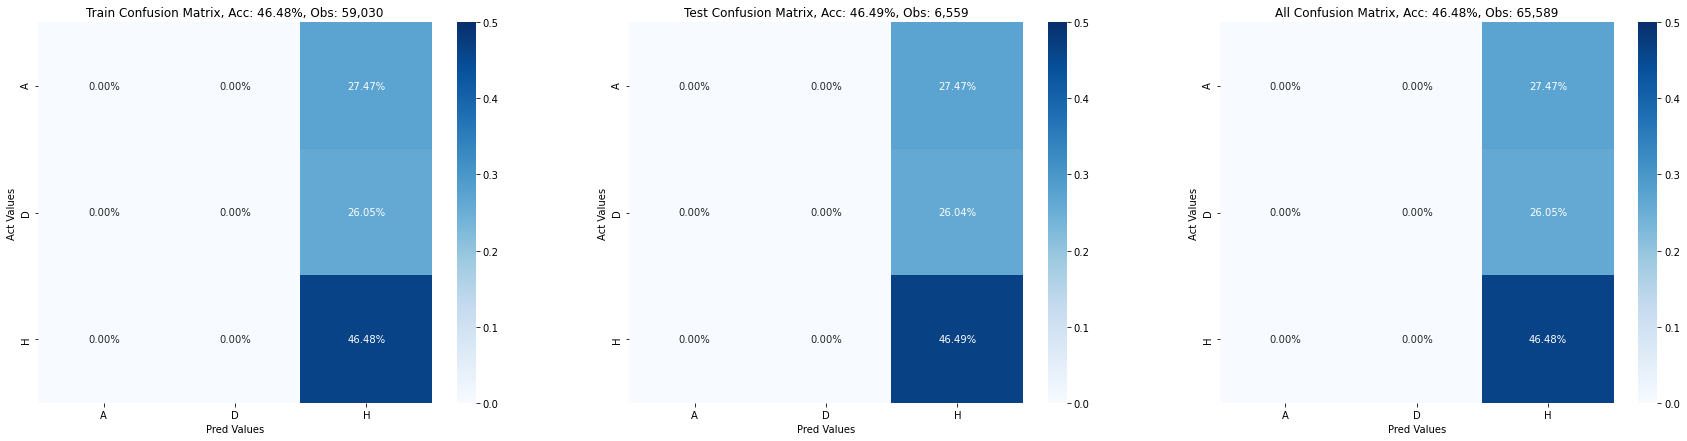

In [36]:
pp_conf_matrices(list_of_act_preds, max_val=0.5)

Given we have a simple 1 factor model for 'Home' only it is not surprising:
 - We only ever predict home due to the higher lambda for all home games
 - Home advantage holds for approx ~46% of games which is the accuracy of the model

This gives us a baseline --> ~46% is the min required to beat a naive model that only predicts home

#### 3h. Accuracy by Score

Can now try to bucket accuracy by scoreline

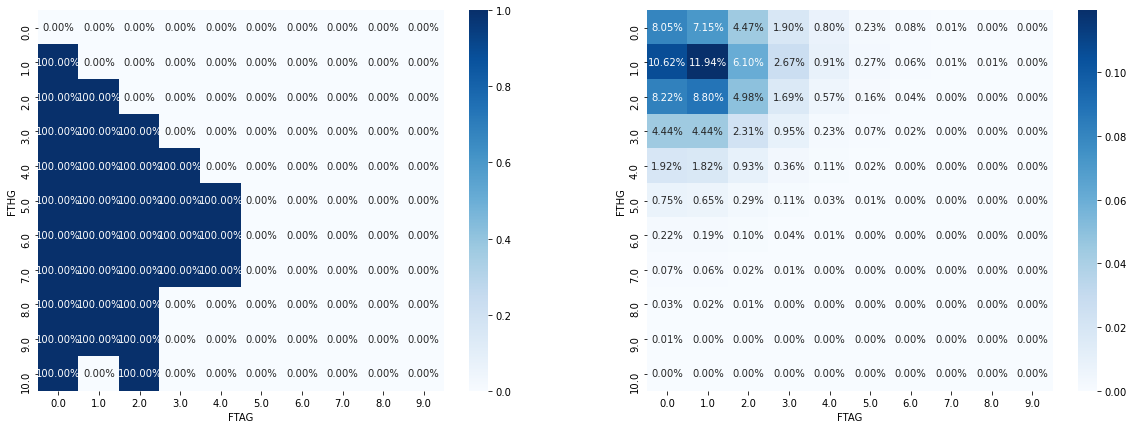

In [39]:
eval_score_df = eval_df[['FTR', 'FTRPred', 'FTHG', 'FTAG']]
eval_score_df['Correct'] = eval_score_df['FTR'] == eval_score_df['FTRPred']
acc_by_score = eval_score_df[['Correct','FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).sum() / eval_score_df[['Correct','FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).count()

fig, axes = plt.subplots(ncols=2, figsize=(20,7))

sns.heatmap(pd.pivot_table(acc_by_score, index='FTHG', columns='FTAG', values='Correct').fillna(0), cmap='Blues', fmt='.2%', annot=True, ax=axes[0]);
sns.heatmap(pd.pivot_table(eval_score_df[['Correct','FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).count() / eval_score_df.shape[0], index='FTHG', columns='FTAG', values='Correct').fillna(0), cmap='Blues', fmt='.2%', annot=True, ax=axes[1]);

From above:
 - Right heatmap shows % of games that end in a given scoreline e.g. 1-1 draws happen 12% of the time
 - Left heatmap shows from each scoreline, what % of them we predict correctly
 - Clearly we predict all home wins correctly as that is all we ever predict (at the detriment of 0% of draws and away wins)

## 4. Slighlty Less Simple Model - Long Run GF/GA

### 4a. GF / GA Exploration

Before creating the model, we can check to see whether or not we anticipate historical Goals Scored/For (GF) and Goals Conceded/Against (GA) to have any impact on the scoreline of a game

In [44]:
actual_cols = ['GF', 'GA']

team_gf = ['TeamAvgGF_'+str(x) for x in [3,5,10,20,40,80]]
opp_ga = ['OppAvgGA_'+str(x) for x in [3,5,10,20,40,80]]

team_ga = ['TeamAvgGA_'+str(x) for x in [3,5,10,20,40,80]]
opp_gf = ['OppAvgGF_'+str(x) for x in [3,5,10,20,40,80]]

df_gfga = df[['Date', 'Div', 'Season', 'Team', 'Opp'] + actual_cols + team_gf + opp_ga + team_ga + opp_gf]
df_gfga.tail()

,Date,Div,Season,Team,Opp,GF,GA,TeamAvgGF_3,TeamAvgGF_5,TeamAvgGF_10,TeamAvgGF_20,TeamAvgGF_40,TeamAvgGF_80,OppAvgGA_3,OppAvgGA_5,OppAvgGA_10,OppAvgGA_20,OppAvgGA_40,OppAvgGA_80,TeamAvgGA_3,TeamAvgGA_5,TeamAvgGA_10,TeamAvgGA_20,TeamAvgGA_40,TeamAvgGA_80,OppAvgGF_3,OppAvgGF_5,OppAvgGF_10,OppAvgGF_20,OppAvgGF_40,OppAvgGF_80
131173,2020-12-13,E0,2021,Tottenham,Crystal Palace,1.0,1.0,1.333333,1.4,2.3,1.85,1.725,1.7125,1.333333,1.4,1.6,1.70,1.400,1.3875,0.000000,0.2,0.8,0.8,1.075,1.1000,1.666667,1.8,1.6,1.10,1.000,1.1750
131174,2020-12-13,SP1,2021,Villarreal,Betis,1.0,1.0,0.666667,1.4,1.2,1.55,1.350,1.5125,2.000000,2.4,2.3,1.75,1.575,1.6125,0.666667,0.6,0.9,1.1,1.150,1.3125,0.666667,1.4,1.1,1.10,1.250,1.2625
131175,2020-12-13,B1,2021,Waasland-Beveren,Mechelen,3.0,2.0,1.666667,1.4,1.4,1.15,0.975,1.0625,2.000000,2.0,2.1,1.55,1.725,1.6125,0.333333,0.6,1.6,2.1,1.950,1.8625,1.666667,2.0,1.7,1.65,1.500,1.3625
131176,2020-12-14,SP1,2021,Cadiz,Celta,0.0,4.0,1.000000,1.0,0.9,0.80,0.950,1.1375,1.666667,2.0,1.9,1.70,1.425,1.4875,1.000000,1.4,1.1,1.0,1.025,0.9250,2.333333,1.8,1.1,1.10,1.125,1.1250
131177,2020-12-14,SP1,2021,Celta,Cadiz,4.0,0.0,2.333333,1.8,1.1,1.10,1.125,1.1250,1.000000,1.4,1.1,1.00,1.025,0.9250,1.666667,2.0,1.9,1.7,1.425,1.4875,1.000000,1.0,0.9,0.80,0.950,1.1375


#### Historical Team GF vs GF

Can plot rolling historical averages vs GF in a game to try and tease out any meaningful correlations

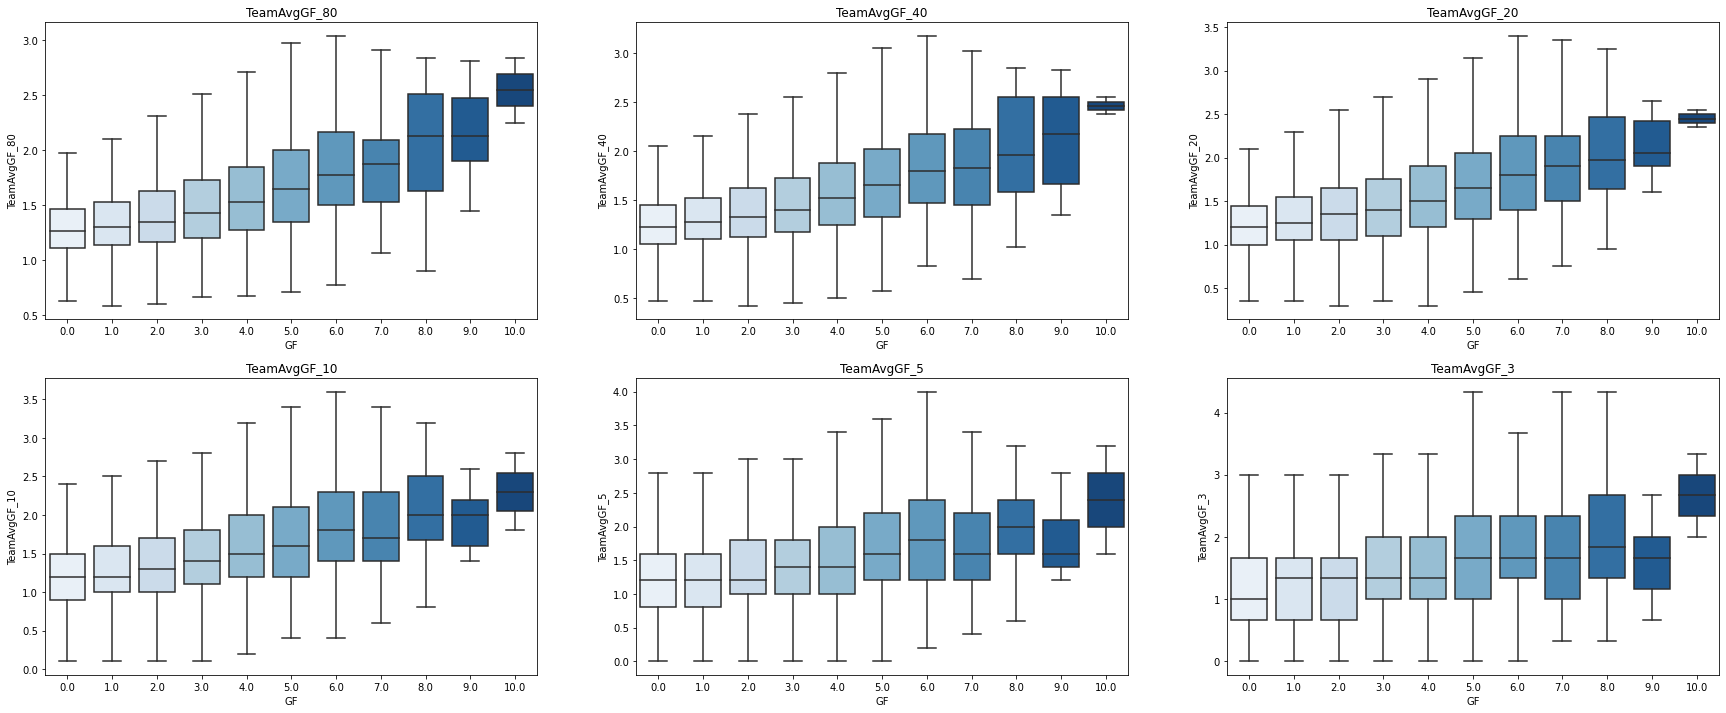

In [60]:
nc = 3
nr = 2
fig, axes = plt.subplots(ncols=nc, nrows=nr, figsize=(10*nc, 6*nr))
axes = axes.reshape(-1)

for gf,a in zip(team_gf[::-1], axes):
    sns.boxplot(data=df_gfga, x='GF', y=gf, palette='Blues', ax=a, showfliers = False);
    a.set_title(gf)

Takeaways:
 - Overall positive correlation across the board --> a higher rolling avg goals scored can only be positive for expected GF
 - Stronger positive correlation over a longer time horizon e.g. 80 vs 3
 - This may be because over 3 games you may be a good team but play 3 also very good teams i.e. __the historical rolling averages are not taking into account the team they were scored against__

#### Historical Opp GA vs GF

Can now do the same for how may goals yur opponent has let in on avg over the last $n$ games

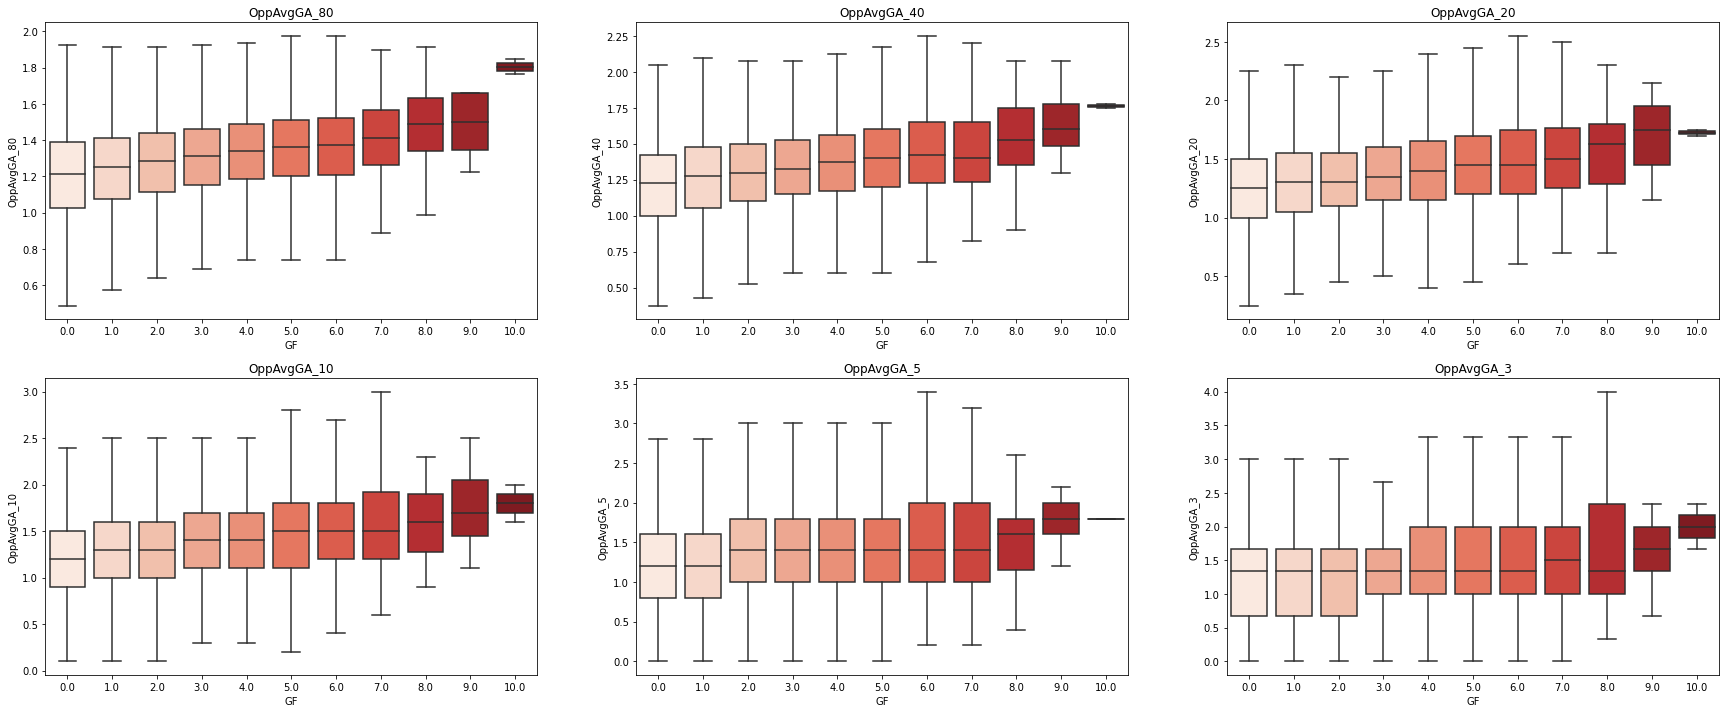

In [61]:
nc = 3
nr = 2
fig, axes = plt.subplots(ncols=nc, nrows=nr, figsize=(10*nc, 6*nr))
axes = axes.reshape(-1)

for gf,a in zip(opp_ga[::-1], axes):
    sns.boxplot(data=df_gfga, x='GF', y=gf, palette='Reds', ax=a, showfliers = False);
    a.set_title(gf)

Takeaways:
 - Again, on average a positive correlation across all --> play 'on average' a 'leaky' opponent and you are expected to score more goals
 - Again, longer time horizons appear to have a higher correlation than shorter ones

#### Team GA vs GF

Would still expect this to have an impact, but:
 - Less so vs Team GF i.e. how does your defence impact your goals scored
 - Potentially would vanish once correlation with Team GF taken account of i.e. if you score goals then your opponent less likely to have the ball to score against you

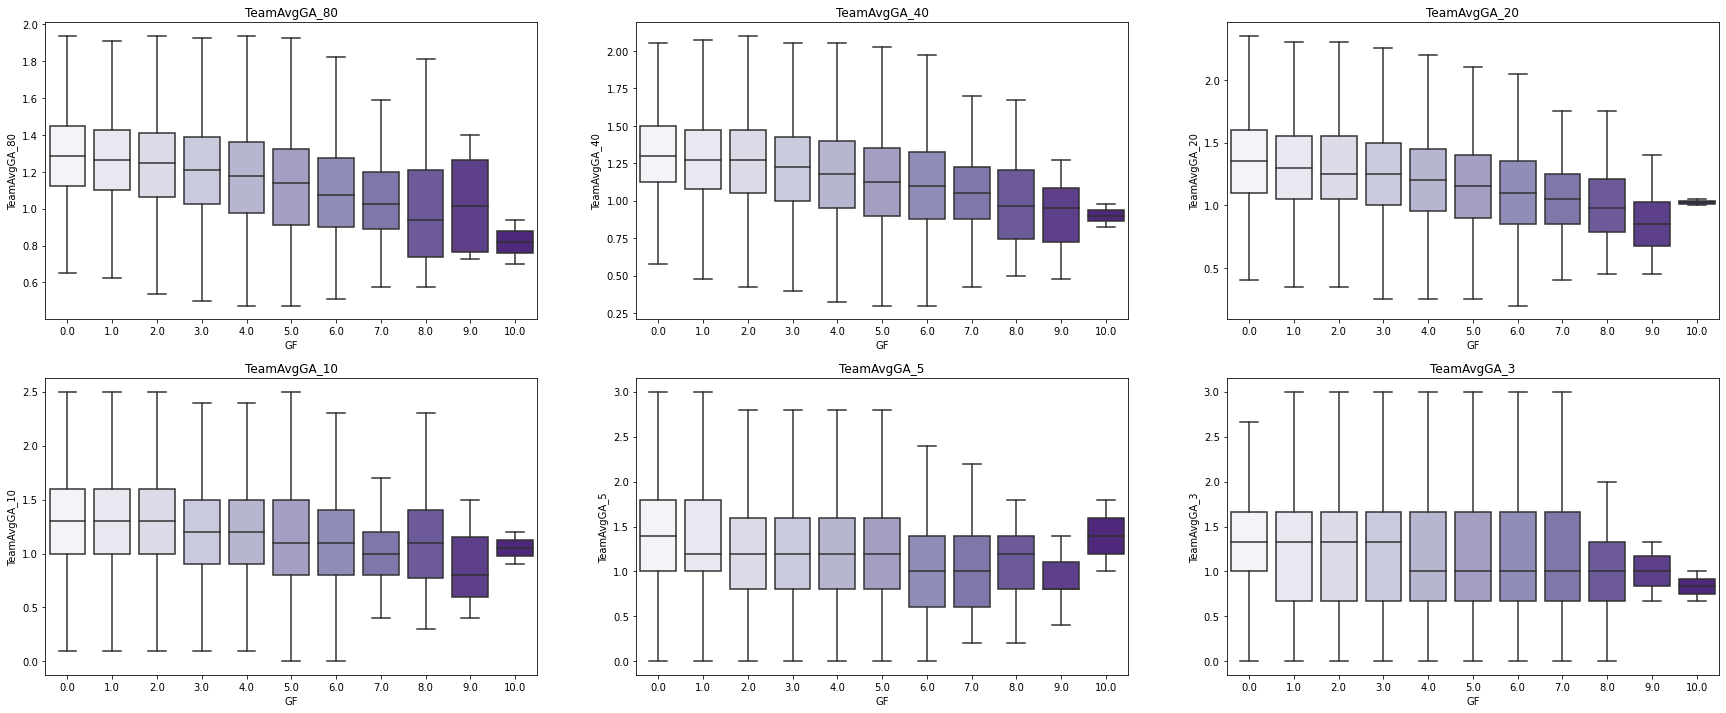

In [63]:
nc = 3
nr = 2
fig, axes = plt.subplots(ncols=nc, nrows=nr, figsize=(10*nc, 6*nr))
axes = axes.reshape(-1)

for gf,a in zip(team_ga[::-1], axes):
    sns.boxplot(data=df_gfga, x='GF', y=gf, palette='Purples', ax=a, showfliers = False);
    a.set_title(gf)

#### Opp GF vs GF

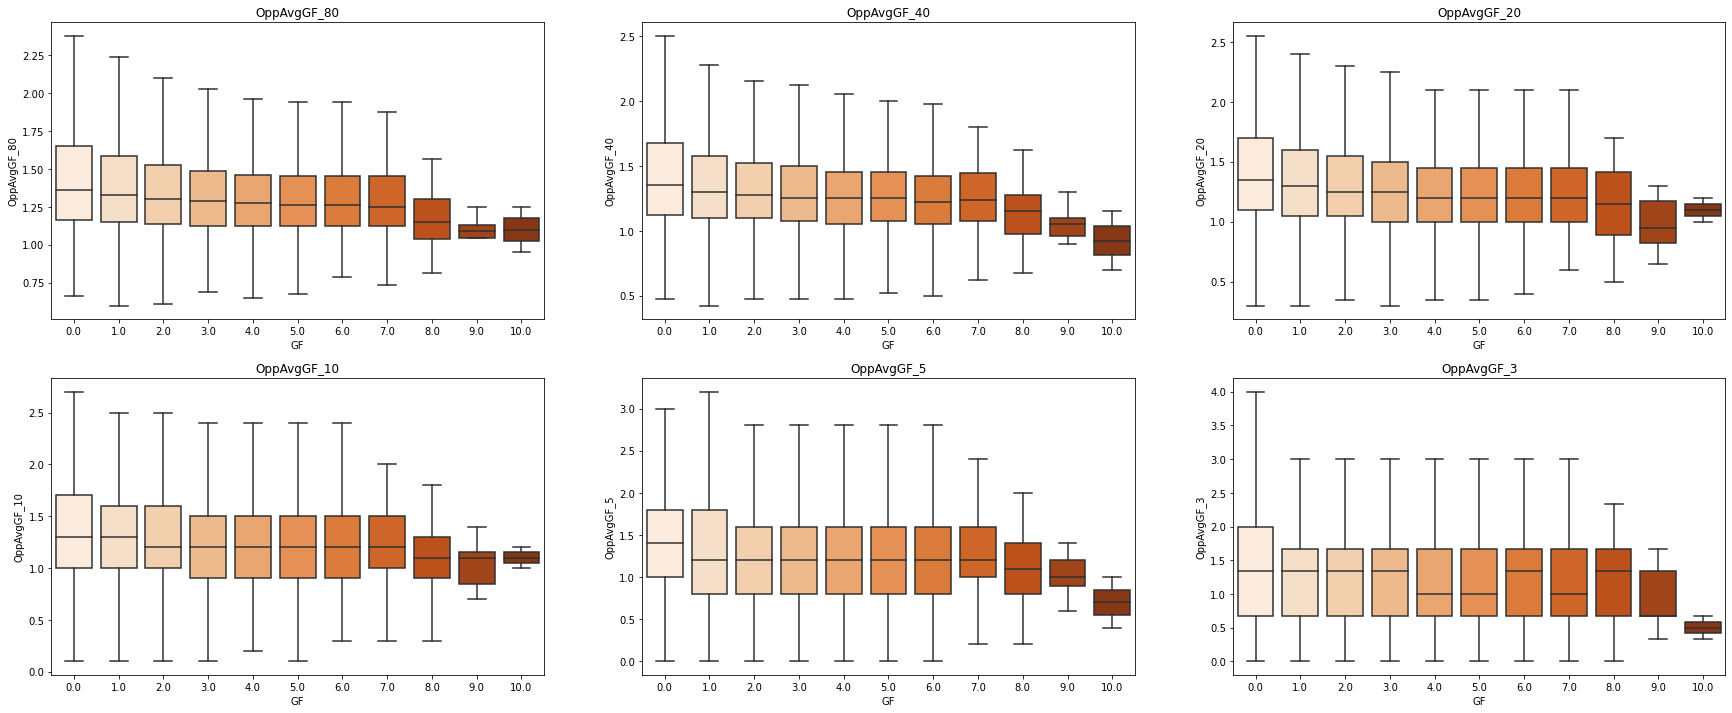

In [64]:
nc = 3
nr = 2
fig, axes = plt.subplots(ncols=nc, nrows=nr, figsize=(10*nc, 6*nr))
axes = axes.reshape(-1)

for gf,a in zip(opp_gf[::-1], axes):
    sns.boxplot(data=df_gfga, x='GF', y=gf, palette='Oranges', ax=a, showfliers = False);
    a.set_title(gf)

As expected both 4c and 4d display less correlation but still could be worth including

__Now let's try a basic model of only including long term averages i.e. only 40 and 80 (roughly 1 & 2 prem league seasons worth of results)__

### 4b. Preprocess

Now let's try and fit various models

In [66]:
pred_col = 'GF'
train_col = ['Train']

feats = ['Home']
stand_feats = [x for x in (team_gf + opp_ga + team_ga + opp_gf) if '40' in x or '80' in x]
norm_feats = []
all_feats = feats + stand_feats + norm_feats

df_est = df[[pred_col] + train_col + all_feats].dropna()
print('From original df with {:,} obs, have dropped {:,} NaNs'.format(len(df), len(df) - len(df_est)))
df_est.tail()

From original df with 131,178 obs, have dropped 17,480 NaNs


,GF,Train,Home,TeamAvgGF_40,TeamAvgGF_80,OppAvgGA_40,OppAvgGA_80,TeamAvgGA_40,TeamAvgGA_80,OppAvgGF_40,OppAvgGF_80
131173,1.0,False,0,1.725,1.7125,1.400,1.3875,1.075,1.1000,1.000,1.1750
131174,1.0,True,0,1.350,1.5125,1.575,1.6125,1.150,1.3125,1.250,1.2625
131175,3.0,True,0,0.975,1.0625,1.725,1.6125,1.950,1.8625,1.500,1.3625
131176,0.0,True,0,0.950,1.1375,1.425,1.4875,1.025,0.9250,1.125,1.1250
131177,4.0,True,1,1.125,1.1250,1.025,0.9250,1.425,1.4875,0.950,1.1375


__Train/Test Split__

In [67]:
X = df_est[all_feats]
y = df_est[pred_col]

x_train = df_est[df_est.Train][all_feats]
x_test = df_est[~df_est.Train][all_feats]

y_train = df_est[df_est.Train][pred_col]
y_test = df_est[~df_est.Train][pred_col]

print('Using {:,} cases for training'.format(x_train.shape[0]))
print('---')
print('Using {:,} cases for testing'.format(x_test.shape[0]))
print('---')
print('Using following factors to predict: {}'.format(', '.join(all_feats)))

Using 102,408 cases for training
---
Using 11,290 cases for testing
---
Using following factors to predict: Home, TeamAvgGF_40, TeamAvgGF_80, OppAvgGA_40, OppAvgGA_80, TeamAvgGA_40, TeamAvgGA_80, OppAvgGF_40, OppAvgGF_80


__Apply Scaling__

In [68]:
x_train, std_scaler, norm_scaler = apply_feature_scaling(x_train, stand_feats, norm_feats)

### 4c. Fit Model

In [69]:
# boolean to decide to add intercept term (sklearn does by default)
add_int = True
# create a Poisson GLM class
poisson_model = sm.GLM(y_train, (sm.add_constant(x_train) if add_int else x_train), family=sm.families.Poisson())
# fit the model
model = poisson_model.fit()

In [70]:
model_output = statsmodels_pretty_print(model, alpha=0.05, dp=2, model_overview=True, param_sort_cols=['Sig', 'coef'])
model_output


__Estimating a Poisson GLM model__
<br>
__Model Overview__
<br>
Assume underlying discrete variable $z_i$ has a poisson distribution - we want to estimate for a set of data $[y_i, X_i]$ what this $\lambda_i$ should be
<br>
Utilising the $e$ to ensure $\lambda>0$ we thus have the following model specification:
<br>
$$\lambda_i = e^{\alpha + \beta X_i}$$
<br>
Utilising a log link function we thus use MLE to estimate the following equation:
<br>
$$ln(\lambda_i) = \alpha + \beta X_i$$
Solving steps:
- Estimate values for $\alpha$ and $\beta$
- Using data for $X_i$ obtain estimates for $\lambda_i$
- Use these to generate $P(z_i = k | \lambda_i)$ for all observations
- Use max likelihood function to see how we did - then iterate on $\alpha$ and $\beta$ to maximise likelihood function


__Model Output__

,coef,lb,ub,p,z,Sig,coef_mag
Home,1.36,1.34,1.37,0.00,56.05,True,0.36
TeamAvgGF_80,1.12,1.10,1.13,0.00,16.58,True,0.12
const,1.09,1.08,1.10,0.00,21.15,True,0.09
TeamAvgGF_40,1.07,1.06,1.09,0.00,10.83,True,0.07
OppAvgGA_40,1.06,1.05,1.08,0.00,11.36,True,0.06
OppAvgGA_80,1.05,1.04,1.06,0.00,8.09,True,0.05
OppAvgGF_40,0.96,0.95,0.98,0.00,-5.52,True,0.04
OppAvgGF_80,0.97,0.95,0.98,0.00,-4.83,True,0.03
TeamAvgGA_40,0.97,0.96,0.98,0.00,-4.86,True,0.03
TeamAvgGA_80,0.99,0.98,1.00,0.24,-1.17,False,0.01


Comments on GLM Regression results:
 - Home adv still the most important factor i.e. it still gives 1.36x more likely to score at home
 - As _kinda_ demonstrated in the above series of boxplots, historical avgs of GF are most correlated i.e. TeamGF_40 and TeamGF_80
 - All coefficients are of expected sign (TeamGF>1, OppGA>1 and vice versa) and all highly significant (apart from TeamGA_80)

### 4d. Eval

In [71]:
eval_df = statsmodels_create_eval_df('all', model, add_int, X, y, x_train, x_test, y_train, y_test, stand_feats, norm_feats, std_scaler, norm_scaler)
eval_df.tail()

,GF,Home,TeamAvgGF_40,TeamAvgGF_80,OppAvgGA_40,OppAvgGA_80,TeamAvgGA_40,TeamAvgGA_80,OppAvgGF_40,OppAvgGF_80,lambda
131173,1.0,0,0.884565,0.907866,0.414241,0.523272,-0.656261,-0.597245,-0.976899,-0.625315,1.468323
131174,1.0,0,-0.078261,0.337380,0.990666,1.400199,-0.409222,0.230964,-0.335015,-0.375727,1.325373
131175,3.0,0,-1.041087,-0.946213,1.484744,1.400199,2.225861,2.374562,0.306869,-0.090484,0.978985
131176,0.0,0,-1.105276,-0.732281,0.496588,0.913018,-0.820954,-1.279299,-0.655957,-0.767936,1.086385
131177,4.0,1,-0.655957,-0.767936,-0.820954,-1.279299,0.496588,0.913018,-1.105276,-0.732281,1.222592


In [72]:
# create the poisson distribution per team and then form by match
eval_df = create_poisson_prediction_output(eval_df, df, ['Country', 'Div', 'Season', 'Train'])
eval_df = eval_df.sort_values(['Date', 'Country', 'Div'])
eval_df.tail()

,Date,HomeTeam,AwayTeam,Country,Div,Season,Train,FTR,FTHG,FTAG,HomeLambda,AwayLambda,HomeGoalProbs,AwayGoalProbs,HomeMaxProbGoals,AwayMaxProbGoals,GoalMatrix,AwayProb,DrawProb,HomeProb,FTRProbs,FTRPred,Score,MaxProbScore
56823,2020-12-13,Barcelona,Levante,spain,SP1,2021,True,H,1.0,0.0,2.541088,0.788933,"[0.07878064850229709, 0.20018855184869974, 0.2...","[0.45432924796435115, 0.35843539473939073, 0.1...",3,1,"[[0.035792352788192525, 0.028237772843746047, ...",0.094028,0.152604,0.708382,"(0.09402751949736182, 0.15260436511377426, 0.7...",H,"(1.0, 0.0)","(3, 1)"
56824,2020-12-13,Betis,Villarreal,spain,SP1,2021,True,D,1.0,1.0,1.309944,1.325373,"[0.2698351087066518, 0.35346893966389836, 0.23...","[0.2657037733437162, 0.35215666691749586, 0.23...",2,2,"[[0.07169620656396923, 0.09502423249945466, 0....",0.370228,0.261832,0.363178,"(0.3702276765388536, 0.2618324098537328, 0.363...",A,"(1.0, 1.0)","(2, 2)"
56831,2020-12-13,Elche,Granada,spain,SP1,2021,False,A,0.0,1.0,1.424456,0.974432,"[0.24063939851076804, 0.3427801719406161, 0.24...","[0.3774064816119239, 0.3677571307552598, 0.179...",2,1,"[[0.0908188687291586, 0.08849685474299158, 0.0...",0.257292,0.267987,0.470723,"(0.2572923818797396, 0.2679868437630984, 0.470...",H,"(0.0, 1.0)","(2, 1)"
56845,2020-12-13,Sociedad,Eibar,spain,SP1,2021,True,D,1.0,1.0,1.685066,0.831398,"[0.18543221359252582, 0.31246549786432704, 0.2...","[0.4354399186859736, 0.3620240741586588, 0.150...",2,1,"[[0.08074458800848953, 0.06713092544502482, 0....",0.183087,0.240221,0.568786,"(0.18308671711634983, 0.24022129356234534, 0.5...",H,"(1.0, 1.0)","(2, 1)"
56848,2020-12-14,Celta,Cadiz,spain,SP1,2021,True,H,4.0,0.0,1.222592,1.086385,"[0.2944658661526204, 0.36001166730029605, 0.22...","[0.33743426715265756, 0.366583375025456, 0.199...",2,2,"[[0.09936287374668201, 0.10794629104402177, 0....",0.324436,0.282192,0.390819,"(0.32443603955995, 0.28219200146003115, 0.3908...",H,"(4.0, 0.0)","(2, 2)"


In [73]:
list_of_act_preds = [
    {'act': eval_df[eval_df['Train']]['FTR'],
     'pred': eval_df[eval_df['Train']]['FTRPred'],
     'label': 'Train'
    },
    {'act': eval_df[~eval_df['Train']]['FTR'],
     'pred': eval_df[~eval_df['Train']]['FTRPred'],
     'label': 'Test'
    },
    {'act': eval_df['FTR'],
     'pred': eval_df['FTRPred'],
     'label': 'All'
    }
]

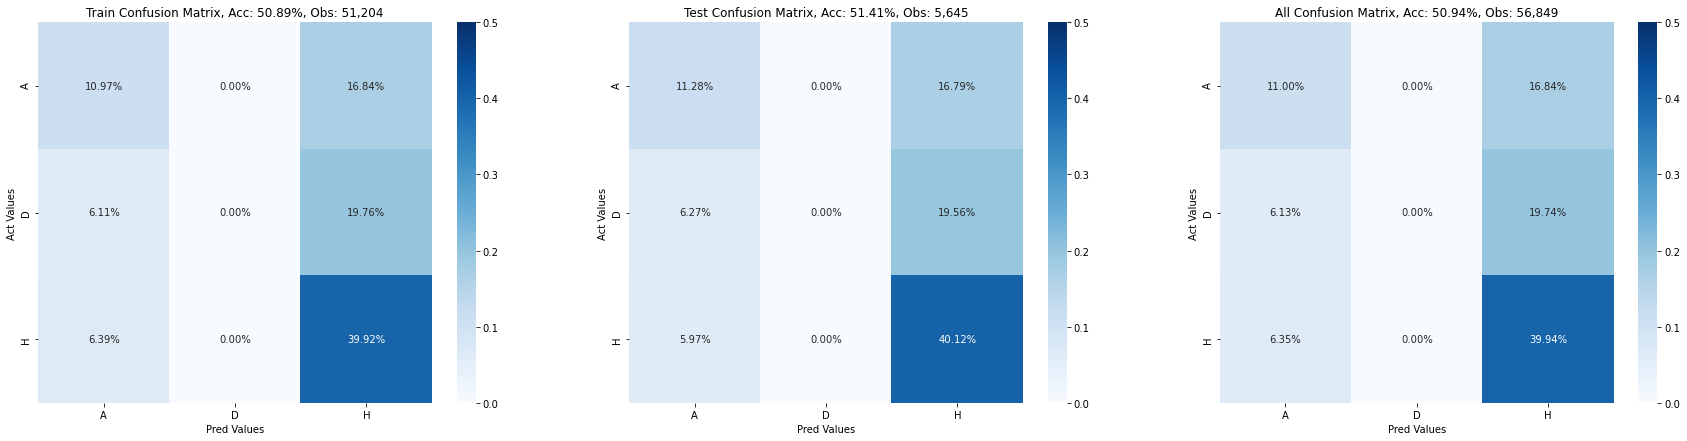

In [74]:
pp_conf_matrices(list_of_act_preds, max_val=0.5)

So by adding these long run performance features we:
 - Start predicting some away wins(~23% away)
 - Still never predict a draw
 - __Improve our accuracy vs the simplistic 'H' only model by ~5%__

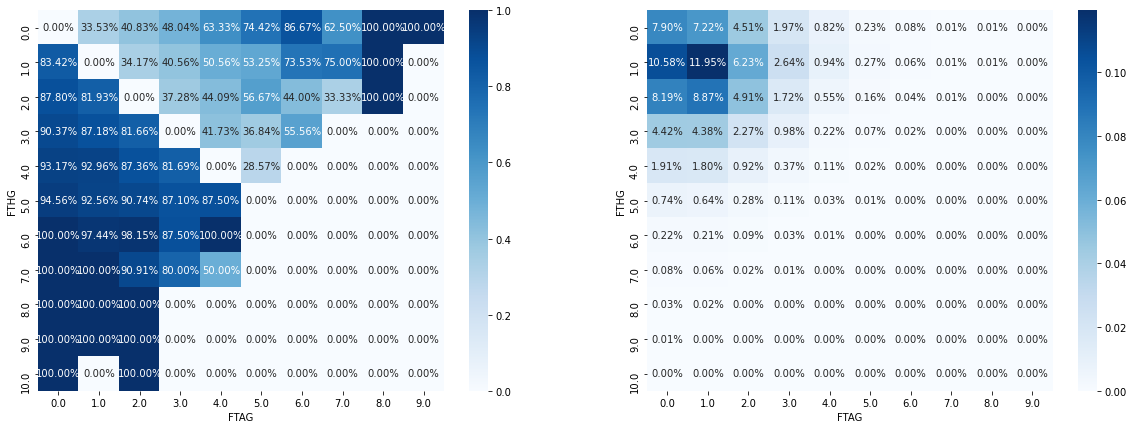

In [75]:
eval_score_df = eval_df[['FTR', 'FTRPred', 'FTHG', 'FTAG']]
eval_score_df['Correct'] = eval_score_df['FTR'] == eval_score_df['FTRPred']
acc_by_score = eval_score_df[['Correct','FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).sum() / eval_score_df[['Correct','FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).count()

fig, axes = plt.subplots(ncols=2, figsize=(20,7))

sns.heatmap(pd.pivot_table(acc_by_score, index='FTHG', columns='FTAG', values='Correct').fillna(0), cmap='Blues', fmt='.2%', annot=True, ax=axes[0]);
sns.heatmap(pd.pivot_table(eval_score_df[['Correct','FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).count() / eval_score_df.shape[0], index='FTHG', columns='FTAG', values='Correct').fillna(0), cmap='Blues', fmt='.2%', annot=True, ax=axes[1]);

Compared to the H-only model:
 - We still predict a large % of the H matches correctly
 - We start to predict some of the A matches correctly (at the detriment of 100% for home matches)
 - Struggle most to predict low scoring away victories (34% 0-1, 41% 0-2, 34% 1-2) despite them being more common in practise
 
It's an improvement, but the key to better results seems to lie in:
 - Predicting draws
 - Predicting low scoring away victories
 
Home advantage still seems to have too big an impact on the estimated $\lambda$ that can't be overcome by (currently) included features

## 5. Even Less Simple Model - Long + Short Run GF/GA

Now we try to incorporate some of the more short term averages in an attempt to incorporate 'form'

As noted above:
 - they appear to have a lower correlation with GF than longer run averages
 - this is likely as they are simple linear averages and each goal is not weighted by likelihood of scoring i.e. quality of opposition is not taken into account

### 5a. Preprocess

Now let's try and fit various models

In [76]:
pred_col = 'GF'
train_col = ['Train']

feats = ['Home']
stand_feats = team_gf + opp_ga + team_ga + opp_gf
norm_feats = []
all_feats = feats + stand_feats + norm_feats

df_est = df[[pred_col] + train_col + all_feats].dropna()
print('From original df with {:,} obs, have dropped {:,} NaNs'.format(len(df), len(df) - len(df_est)))
df_est.tail()

From original df with 131,178 obs, have dropped 17,480 NaNs


,GF,Train,Home,TeamAvgGF_3,TeamAvgGF_5,TeamAvgGF_10,TeamAvgGF_20,TeamAvgGF_40,TeamAvgGF_80,OppAvgGA_3,OppAvgGA_5,OppAvgGA_10,OppAvgGA_20,OppAvgGA_40,OppAvgGA_80,TeamAvgGA_3,TeamAvgGA_5,TeamAvgGA_10,TeamAvgGA_20,TeamAvgGA_40,TeamAvgGA_80,OppAvgGF_3,OppAvgGF_5,OppAvgGF_10,OppAvgGF_20,OppAvgGF_40,OppAvgGF_80
131173,1.0,False,0,1.333333,1.4,2.3,1.85,1.725,1.7125,1.333333,1.4,1.6,1.70,1.400,1.3875,0.000000,0.2,0.8,0.8,1.075,1.1000,1.666667,1.8,1.6,1.10,1.000,1.1750
131174,1.0,True,0,0.666667,1.4,1.2,1.55,1.350,1.5125,2.000000,2.4,2.3,1.75,1.575,1.6125,0.666667,0.6,0.9,1.1,1.150,1.3125,0.666667,1.4,1.1,1.10,1.250,1.2625
131175,3.0,True,0,1.666667,1.4,1.4,1.15,0.975,1.0625,2.000000,2.0,2.1,1.55,1.725,1.6125,0.333333,0.6,1.6,2.1,1.950,1.8625,1.666667,2.0,1.7,1.65,1.500,1.3625
131176,0.0,True,0,1.000000,1.0,0.9,0.80,0.950,1.1375,1.666667,2.0,1.9,1.70,1.425,1.4875,1.000000,1.4,1.1,1.0,1.025,0.9250,2.333333,1.8,1.1,1.10,1.125,1.1250
131177,4.0,True,1,2.333333,1.8,1.1,1.10,1.125,1.1250,1.000000,1.4,1.1,1.00,1.025,0.9250,1.666667,2.0,1.9,1.7,1.425,1.4875,1.000000,1.0,0.9,0.80,0.950,1.1375


__Train/Test Split__

In [77]:
X = df_est[all_feats]
y = df_est[pred_col]

x_train = df_est[df_est.Train][all_feats]
x_test = df_est[~df_est.Train][all_feats]

y_train = df_est[df_est.Train][pred_col]
y_test = df_est[~df_est.Train][pred_col]

print('Using {:,} cases for training'.format(x_train.shape[0]))
print('---')
print('Using {:,} cases for testing'.format(x_test.shape[0]))
print('---')
print('Using following factors to predict: {}'.format(', '.join(all_feats)))

Using 102,408 cases for training
---
Using 11,290 cases for testing
---
Using following factors to predict: Home, TeamAvgGF_3, TeamAvgGF_5, TeamAvgGF_10, TeamAvgGF_20, TeamAvgGF_40, TeamAvgGF_80, OppAvgGA_3, OppAvgGA_5, OppAvgGA_10, OppAvgGA_20, OppAvgGA_40, OppAvgGA_80, TeamAvgGA_3, TeamAvgGA_5, TeamAvgGA_10, TeamAvgGA_20, TeamAvgGA_40, TeamAvgGA_80, OppAvgGF_3, OppAvgGF_5, OppAvgGF_10, OppAvgGF_20, OppAvgGF_40, OppAvgGF_80


__Apply Scaling__

In [78]:
x_train, std_scaler, norm_scaler = apply_feature_scaling(x_train, stand_feats, norm_feats)

### 4c. Fit Model

In [79]:
# boolean to decide to add intercept term (sklearn does by default)
add_int = True
# create a Poisson GLM class
poisson_model = sm.GLM(y_train, (sm.add_constant(x_train) if add_int else x_train), family=sm.families.Poisson())
# fit the model
model = poisson_model.fit()

In [80]:
model_output = statsmodels_pretty_print(model, alpha=0.05, dp=2, model_overview=True, param_sort_cols=['Sig', 'coef'])
model_output


__Estimating a Poisson GLM model__
<br>
__Model Overview__
<br>
Assume underlying discrete variable $z_i$ has a poisson distribution - we want to estimate for a set of data $[y_i, X_i]$ what this $\lambda_i$ should be
<br>
Utilising the $e$ to ensure $\lambda>0$ we thus have the following model specification:
<br>
$$\lambda_i = e^{\alpha + \beta X_i}$$
<br>
Utilising a log link function we thus use MLE to estimate the following equation:
<br>
$$ln(\lambda_i) = \alpha + \beta X_i$$
Solving steps:
- Estimate values for $\alpha$ and $\beta$
- Using data for $X_i$ obtain estimates for $\lambda_i$
- Use these to generate $P(z_i = k | \lambda_i)$ for all observations
- Use max likelihood function to see how we did - then iterate on $\alpha$ and $\beta$ to maximise likelihood function


__Model Output__

,coef,lb,ub,p,z,Sig,coef_mag
Home,1.37,1.35,1.38,0.00,56.80,True,0.37
TeamAvgGF_80,1.12,1.10,1.13,0.00,16.74,True,0.12
const,1.09,1.08,1.10,0.00,19.98,True,0.09
OppAvgGA_80,1.05,1.04,1.06,0.00,8.69,True,0.05
OppAvgGF_80,0.97,0.95,0.98,0.00,-5.00,True,0.03
TeamAvgGF_20,1.03,1.01,1.04,0.00,3.92,True,0.03
OppAvgGF_20,0.97,0.96,0.99,0.00,-3.74,True,0.03
OppAvgGA_20,1.02,1.01,1.04,0.00,3.79,True,0.02
OppAvgGA_40,1.02,1.01,1.04,0.00,3.05,True,0.02
OppAvgGA_10,1.02,1.01,1.03,0.00,3.87,True,0.02


Results very similar to long run avg model - little gained

### 4d. Eval

In [81]:
eval_df = statsmodels_create_eval_df('all', model, add_int, X, y, x_train, x_test, y_train, y_test, stand_feats, norm_feats, std_scaler, norm_scaler)
eval_df.tail()

,GF,Home,TeamAvgGF_3,TeamAvgGF_5,TeamAvgGF_10,TeamAvgGF_20,TeamAvgGF_40,TeamAvgGF_80,OppAvgGA_3,OppAvgGA_5,OppAvgGA_10,OppAvgGA_20,OppAvgGA_40,OppAvgGA_80,TeamAvgGA_3,TeamAvgGA_5,TeamAvgGA_10,TeamAvgGA_20,TeamAvgGA_40,TeamAvgGA_80,OppAvgGF_3,OppAvgGF_5,OppAvgGF_10,OppAvgGF_20,OppAvgGF_40,OppAvgGF_80,lambda
131173,1.0,0,-0.014586,0.083542,1.830049,1.106641,0.884565,0.907866,0.017692,0.140242,0.637863,1.099804,0.414241,0.523272,-1.808693,-1.904446,-1.128504,-1.364941,-0.656261,-0.597245,0.421536,0.711087,0.479320,-0.593204,-0.976899,-0.625315,1.522011
131174,1.0,0,-0.886830,0.083542,-0.292524,0.426703,-0.078261,0.337380,0.930884,1.844149,2.183434,1.236734,0.990666,1.400199,-0.895501,-1.222884,-0.907708,-0.543360,-0.409222,0.230964,-0.886830,0.083542,-0.485486,-0.593204,-0.335015,-0.375727,1.435978
131175,3.0,0,0.421536,0.083542,0.093398,-0.479881,-1.041087,-0.946213,0.930884,1.162586,1.741842,0.689013,1.484744,1.400199,-1.352097,-1.222884,0.637863,2.195246,2.225861,2.374562,0.421536,1.024860,0.672282,0.653349,0.306869,-0.090484,1.019305
131176,0.0,0,-0.450708,-0.544004,-0.871408,-1.273142,-1.105276,-0.732281,0.474288,1.162586,1.300250,1.099804,0.496588,0.913018,-0.438905,0.140242,-0.466117,-0.817220,-0.820954,-1.279299,1.293779,0.711087,-0.485486,-0.593204,-0.655957,-0.767936,1.116930
131177,4.0,1,1.293779,0.711087,-0.485486,-0.593204,-0.655957,-0.767936,-0.438905,0.140242,-0.466117,-0.817220,-0.820954,-1.279299,0.474288,1.162586,1.300250,1.099804,0.496588,0.913018,-0.450708,-0.544004,-0.871408,-1.273142,-1.105276,-0.732281,1.227262


In [82]:
# create the poisson distribution per team and then form by match
eval_df = create_poisson_prediction_output(eval_df, df, ['Country', 'Div', 'Season', 'Train'])
eval_df = eval_df.sort_values(['Date', 'Country', 'Div'])
eval_df.tail()

,Date,HomeTeam,AwayTeam,Country,Div,Season,Train,FTR,FTHG,FTAG,HomeLambda,AwayLambda,HomeGoalProbs,AwayGoalProbs,HomeMaxProbGoals,AwayMaxProbGoals,GoalMatrix,AwayProb,DrawProb,HomeProb,FTRProbs,FTRPred,Score,MaxProbScore
56823,2020-12-13,Barcelona,Levante,spain,SP1,2021,True,H,1.0,0.0,2.420569,0.819011,"[0.0888710029157254, 0.21511842719198115, 0.26...","[0.4408675503739629, 0.3610752798064148, 0.147...",3,1,"[[0.039180341354733174, 0.03208912224447225, 0...",0.107440,0.164965,0.690470,"(0.10743978600283953, 0.1649647403597294, 0.69...",H,"(1.0, 0.0)","(3, 1)"
56824,2020-12-13,Betis,Villarreal,spain,SP1,2021,True,D,1.0,1.0,1.210329,1.435978,"[0.2980992100015392, 0.3607980974021841, 0.218...","[0.23788251881219477, 0.3415941458150227, 0.24...",2,2,"[[0.07091259093109155, 0.10182894500860885, 0....",0.419106,0.259253,0.316464,"(0.4191056686494074, 0.25925262162396656, 0.31...",A,"(1.0, 1.0)","(2, 2)"
56831,2020-12-13,Elche,Granada,spain,SP1,2021,False,A,0.0,1.0,1.434516,0.964713,"[0.23823055686849678, 0.34174562839360395, 0.2...","[0.3810923839250013, 0.3676449506581651, 0.177...",2,1,"[[0.09078785084079603, 0.0875842613251857, 0.0...",0.253059,0.267192,0.475658,"(0.25305902429874266, 0.26719161295094696, 0.4...",H,"(0.0, 1.0)","(2, 1)"
56845,2020-12-13,Sociedad,Eibar,spain,SP1,2021,True,D,1.0,1.0,1.714050,0.782056,"[0.18013485710019228, 0.30876006219451085, 0.2...","[0.45746437141516216, 0.35776288179087395, 0.1...",2,1,"[[0.08240527917329953, 0.06444556558715206, 0....",0.167851,0.235887,0.587793,"(0.16785102744494076, 0.23588689772045723, 0.5...",H,"(1.0, 1.0)","(2, 1)"
56848,2020-12-14,Celta,Cadiz,spain,SP1,2021,True,H,4.0,0.0,1.227262,1.116930,"[0.2930939341880518, 0.3597030850373002, 0.220...","[0.3272829796173828, 0.3655522115510717, 0.204...",2,2,"[[0.09592465608884669, 0.1071411358346466, 0.0...",0.331958,0.279959,0.385361,"(0.33195806821089197, 0.27995878474834235, 0.3...",H,"(4.0, 0.0)","(2, 2)"


In [83]:
list_of_act_preds = [
    {'act': eval_df[eval_df['Train']]['FTR'],
     'pred': eval_df[eval_df['Train']]['FTRPred'],
     'label': 'Train'
    },
    {'act': eval_df[~eval_df['Train']]['FTR'],
     'pred': eval_df[~eval_df['Train']]['FTRPred'],
     'label': 'Test'
    },
    {'act': eval_df['FTR'],
     'pred': eval_df['FTRPred'],
     'label': 'All'
    }
]

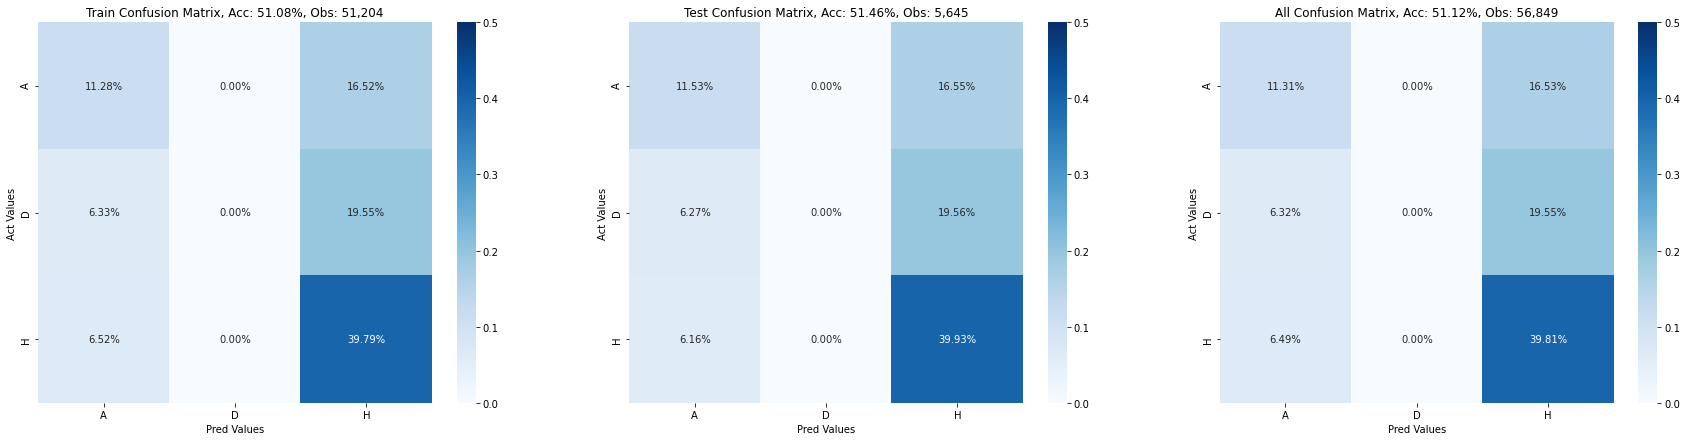

In [84]:
pp_conf_matrices(list_of_act_preds, max_val=0.5)

So by adding these short run performance features we:
 - Still predicting some away wins(~23% away)
 - Still never predict a draw
 - __Accuracy remains unch vs the long run avg only model__

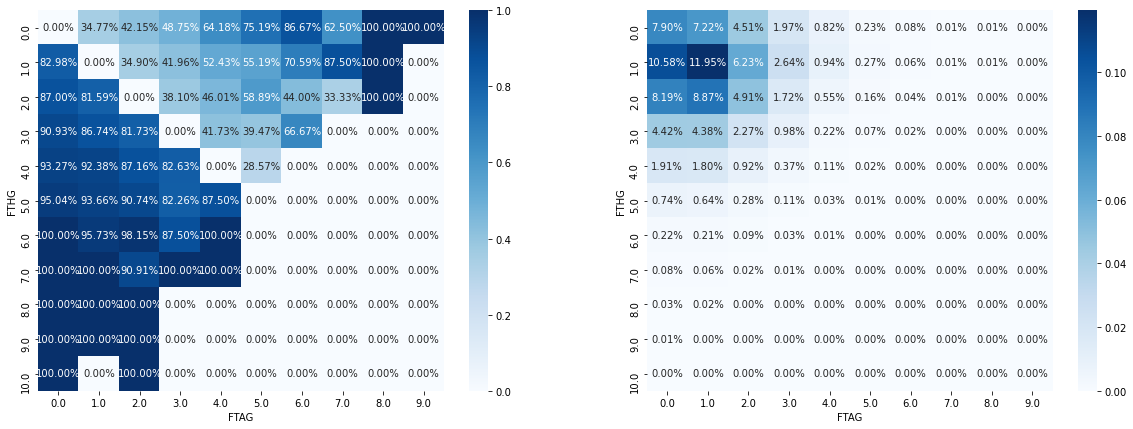

In [85]:
eval_score_df = eval_df[['FTR', 'FTRPred', 'FTHG', 'FTAG']]
eval_score_df['Correct'] = eval_score_df['FTR'] == eval_score_df['FTRPred']
acc_by_score = eval_score_df[['Correct','FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).sum() / eval_score_df[['Correct','FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).count()

fig, axes = plt.subplots(ncols=2, figsize=(20,7))

sns.heatmap(pd.pivot_table(acc_by_score, index='FTHG', columns='FTAG', values='Correct').fillna(0), cmap='Blues', fmt='.2%', annot=True, ax=axes[0]);
sns.heatmap(pd.pivot_table(eval_score_df[['Correct','FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).count() / eval_score_df.shape[0], index='FTHG', columns='FTAG', values='Correct').fillna(0), cmap='Blues', fmt='.2%', annot=True, ax=axes[1]);

As per above, very little gained vs the long run only model

__We need to find a way to incorporate more information on _quality_ of goals into the short run measures so they can more accurately reflect 'form'__